# Model Comparisons

## Configurations

In [1]:
%matplotlib inline
import os
import errno
import warnings
import numpy as np
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import to_hex
from cycler import cycler

In [2]:
# Deal with the bold roman font bug, see
#   https://github.com/matplotlib/matplotlib/issues/5574
matplotlib.font_manager._rebuild()
plt.rc('font', family='serif', size=12)
plt.rc('figure', dpi=120)
plt.rc('savefig', dpi=120)
plt.rc('axes', prop_cycle=(
    cycler(linestyle=['-', '--', '-.', ':']) * 
    cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                  '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])))

In [3]:
SMOOTH = 'med' # 'med', 'avg', None
RESULT_DIR = './figs/'
EXTENSION = 'png' # 'pdf', 'ps', 'eps', 'svg'
EXP_DIRS = [
    ('wgan-gp_g_bn(bn_softmax)_d_ln', '../exp/wgangp/g_bn_relu_bn_softmax_d_ln_relu'),    # 0
    ('wgan-gp_g_bn(bn_softmax)_d_bn', '../exp/wgangp/g_bn_relu_bn_softmax_d_bn_relu'),    # 1
    ('wgan-gp_g_bn(bn_softmax)_d_x', '../exp/wgangp/g_bn_relu_bn_softmax_d_none_relu'),   # 2
    ('wgan-gp_g_bn(bn_x)_d_x', '../exp/wgangp/g_bn_relu_bn_none_d_none_relu'),            # 3
    ('wgan-gp_g_bn(x_softmax)_d_x', '../exp/wgangp/g_bn_relu_none_softmax_d_none_relu'),  # 4
    ('wgan-gp_g_bn(x_x)_d_x', '../exp/wgangp/g_bn_relu_none_none_d_none_relu'),           # 5
    ('wgan-gp_g_ln(ln_softmax)_d_ln', '../exp/wgangp/g_ln_relu_ln_softmax_d_ln_relu'),    # 6
    ('wgan-gp_g_ln(ln_softmax)_d_x', '../exp/wgangp/g_ln_relu_ln_softmax_d_none_relu'),   # 7
    ('wgan-gp_g_ln(x_softmax)_d_ln', '../exp/wgangp/g_ln_relu_none_softmax_d_ln_relu'),   # 8
    ('wgan-gp_g_ln(x_softmax)_d_x', '../exp/wgangp/g_ln_relu_none_softmax_d_none_relu'),  # 9
    ('wgan-gp_g_x(x_softmax)_d_x', '../exp/wgangp/g_none_relu_none_softmax_d_none_relu'), # 10
    ('wgan-gp_g_x(x_x)_d_x', '../exp/wgangp/g_none_relu_none_none_d_none_relu'),          # 11
    ('wgan_g_bn(bn_softmax)_d_ln', '../exp/wgan/g_bn_relu_bn_softmax_d_ln_relu'),         # 12
    ('wgan_g_bn(bn_softmax)_d_x', '../exp/wgan/g_bn_relu_bn_softmax_d_none_relu'),        # 13
    ('gan-gp_g_bn(bn_softmax)_d_ln', '../exp/gan/g_bn_relu_bn_softmax_d_ln_relu'),        # 14
    ('gan-gp_g_bn(bn_softmax)_d_x', '../exp/gan/g_bn_relu_bn_softmax_d_none_relu'),       # 15
]

## Utilities

In [4]:
def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

def movingaverage(values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

def color_variant(hex_color, brightness_offset=1):
    """Takes a hex color code and produces a lighter or darker variant."""
    if len(hex_color) != 7:
        raise ValueError("Unrecognizable color code. Should be like #5F4B8B.")
    rgb_hex = [hex_color[x:x+2] for x in [1, 3, 5]]
    rgb_int = [int(hex_value, 16) + brightness_offset for hex_value in rgb_hex]
    rgb_int = [min([255, max([0, i])]) for i in rgb_int] 
    return "#" + "".join(['{:0>2}'.format(hex(i)[2:]) for i in rgb_int])

def sort_by_max(data, *args):
    sorted_indices = np.argsort(data)[::-1]
    return tuple((np.array(arg)[sorted_indices] for arg in args))

In [5]:
def plot_acc_curve(step, loss, smooth=None, window=5, label=None, raw_linewidth=.2, filepath=None, **kwargs):
    """Plot an accuracy curve."""
    if smooth is None:
        plt.plot(step, loss, label=label, **kwargs)
    else:
        line = plt.plot(step, loss, linewidth=raw_linewidth, zorder=0)
        if smooth == 'med':
            h = (window - 1)//2
            smoothed = scipy.signal.medfilt(loss, window)[h:-h]
            plt.plot(step[h:-h], smoothed, label=label, color=line[0].get_color(),
                     linestyle=line[0].get_linestyle(), **kwargs)
        elif smooth == 'avg':
            h = (window - 1)//2
            plt.plot(step[h:-h], movingaverage(loss, window), label=label, color=line[0].get_color(),
                     linestyle=line[0].get_linestyle(), **kwargs)
        line[0].set_color(color_variant(to_hex(line[0].get_color()), 50))
        line[0].set_linestyle('-')

### Load Data

In [6]:
test_steps, test_accs, train_steps, train_accs = [], [], [], []
for exp_dir in EXP_DIRS:
    # Load test accuracies
    filepath = os.path.join(exp_dir[1], 'logs', 'train', 'val_acc.log')
    test_steps.append(np.loadtxt(filepath, int, delimiter=',', usecols=(0)))
    test_accs.append(np.loadtxt(filepath, float, delimiter=',', usecols=(1)))
    # Load training accuracies
    filepath = os.path.join(exp_dir[1], 'logs', 'train', 'train_losses.log')
    train_steps.append(np.loadtxt(filepath, int, delimiter=',', usecols=(0)))
    train_accs.append(np.loadtxt(filepath, float, delimiter=',', usecols=(3)))

### Performance Table

In [7]:
max_test_accs = []
for i, exp_dir in enumerate(EXP_DIRS):
    max_test_accs.append(test_accs[i].max())
sorted_dirs, sorted_scores = sort_by_max(max_test_accs, EXP_DIRS, max_test_accs)
for i, exp_dir in enumerate(sorted_dirs):
    print("{:32} {:.4}".format(exp_dir[0], sorted_scores[i]))

gan-gp_g_bn(bn_softmax)_d_ln     0.9581
wgan-gp_g_bn(bn_softmax)_d_ln    0.9557
gan-gp_g_bn(bn_softmax)_d_x      0.9522
wgan-gp_g_bn(x_softmax)_d_x      0.9489
wgan-gp_g_ln(x_softmax)_d_x      0.9466
wgan-gp_g_bn(bn_softmax)_d_x     0.9353
wgan-gp_g_ln(ln_softmax)_d_x     0.934
wgan-gp_g_bn(x_x)_d_x            0.9253
wgan-gp_g_bn(bn_x)_d_x           0.9252
wgan-gp_g_x(x_softmax)_d_x       0.9218
wgan-gp_g_ln(x_softmax)_d_ln     0.9178
wgan-gp_g_ln(ln_softmax)_d_ln    0.9072
wgan-gp_g_x(x_x)_d_x             0.8914
wgan-gp_g_bn(bn_softmax)_d_bn    0.8615
wgan_g_bn(bn_softmax)_d_ln       0.8391
wgan_g_bn(bn_softmax)_d_x        0.2898


### Test Accuracy Plots

In [8]:
make_sure_path_exists(RESULT_DIR)

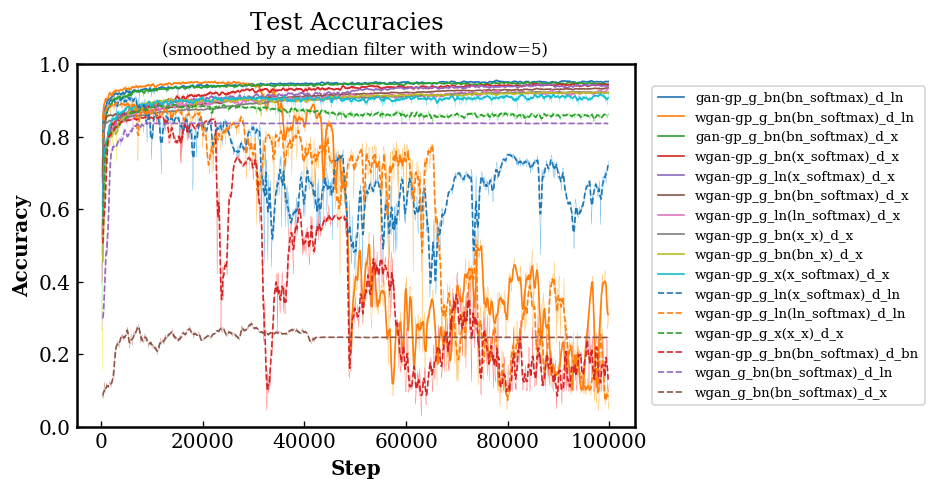

In [9]:
window = 5
sorted_dirs, sorted_steps, sorted_scores = sort_by_max(max_test_accs, EXP_DIRS, test_steps, test_accs)
for i, exp_dir in enumerate(sorted_dirs):
    plot_acc_curve(sorted_steps[i], sorted_scores[i], smooth='avg', window=window,
                   linewidth=1., label=exp_dir[0])
plt.gcf().suptitle('Test Accuracies', y=0.99)
plt.title('(smoothed by a median filter with window={})'.format(window), fontsize=10)
plt.xlabel('Step', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.ylim(0, 1)
plt.tick_params(direction='in')
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.legend(bbox_to_anchor=(1.02, 0.5), loc="center left", prop={'size':8})
plt.savefig(os.path.join(RESULT_DIR, 'test_acc.{}'.format(EXTENSION)), bbox_inches='tight')
plt.show()

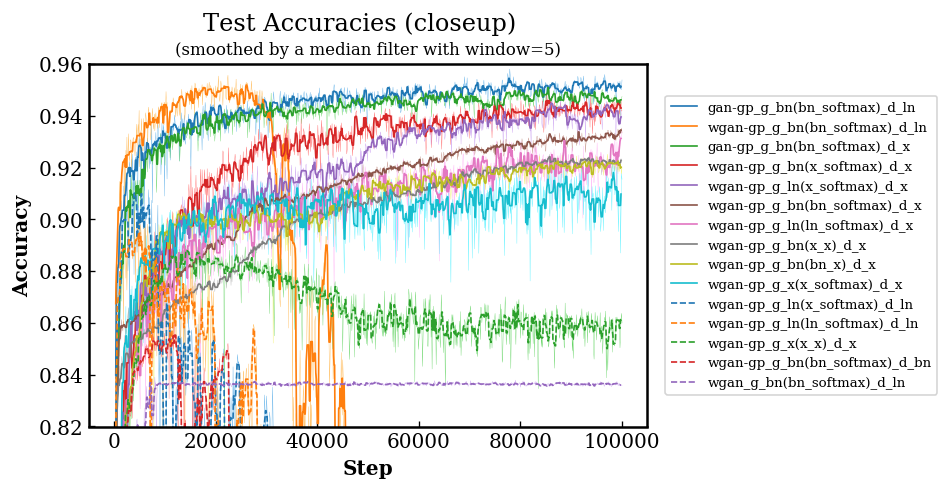

In [10]:
window = 5
sorted_dirs, sorted_steps, sorted_scores = sort_by_max(max_test_accs, EXP_DIRS, test_steps, test_accs)
for i, exp_dir in enumerate(sorted_dirs[:15]):
    plot_acc_curve(sorted_steps[i], sorted_scores[i], smooth='med', window=window,
                   linewidth=1., label=exp_dir[0])
plt.gcf().suptitle('Test Accuracies (closeup)', y=0.99)
plt.title('(smoothed by a median filter with window={})'.format(window), fontsize=10)
plt.xlabel('Step', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.ylim(0.82, 0.96)
plt.yticks(np.arange(0.82, 0.961, 0.02))
plt.tick_params(direction='in')
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.legend(bbox_to_anchor=(1.02, 0.5), loc="center left", prop={'size':8})
plt.savefig(os.path.join(RESULT_DIR, 'test_acc_closeup.{}'.format(EXTENSION)), bbox_inches='tight')
plt.show()

### Training Accuracy Plots

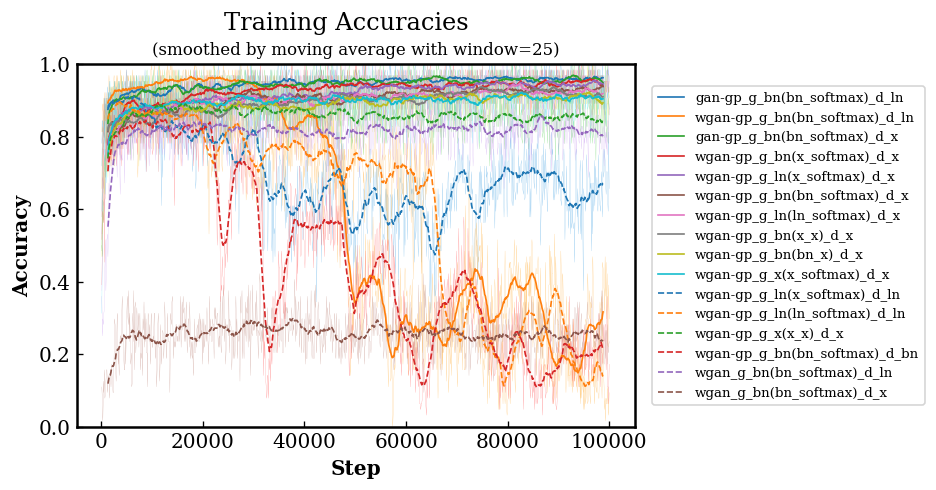

In [11]:
window = 25
sorted_dirs, sorted_steps, sorted_scores = sort_by_max(max_test_accs, EXP_DIRS, train_steps, train_accs)
for i, exp_dir in enumerate(sorted_dirs):
    plot_acc_curve(sorted_steps[i], sorted_scores[i], smooth='avg', window=window,
                   linewidth=1, raw_linewidth=.1, label=exp_dir[0])
plt.tick_params(direction='in')
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.gcf().suptitle('Training Accuracies', y=0.99)
plt.title('(smoothed by moving average with window={})'.format(window), fontsize=10)
plt.xlabel('Step', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.02, 0.5), loc="center left", prop={'size':8})
plt.savefig(os.path.join(RESULT_DIR, 'train_acc.{}'.format(EXTENSION)), bbox_inches='tight')
plt.show()

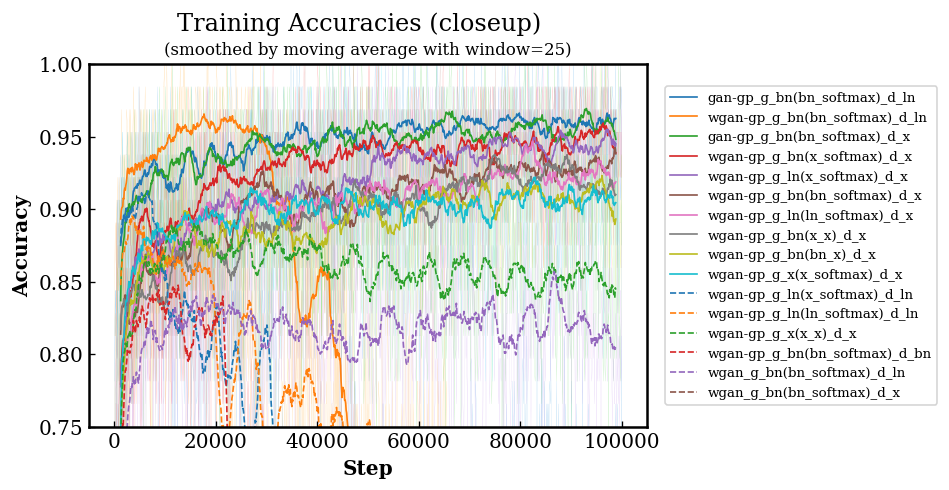

In [12]:
window = 25
sorted_dirs, sorted_steps, sorted_scores = sort_by_max(max_test_accs, EXP_DIRS, train_steps, train_accs)
for i, exp_dir in enumerate(sorted_dirs):
    plot_acc_curve(sorted_steps[i], sorted_scores[i], smooth='avg', window=window,
                   linewidth=1., raw_linewidth=.06, label=exp_dir[0])
plt.gcf().suptitle('Training Accuracies (closeup)', y=0.99)
plt.title('(smoothed by moving average with window={})'.format(window), fontsize=10)
plt.xlabel('Step', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.ylim(0.75, 1)
plt.yticks(np.arange(0.75, 1.01, 0.05))
plt.tick_params(direction='in')
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.legend(bbox_to_anchor=(1.02, 0.5), loc="center left", prop={'size':8})
plt.savefig(os.path.join(RESULT_DIR, 'train_acc_closeup.{}'.format(EXTENSION)), bbox_inches='tight')
plt.show()

## Training Objectives

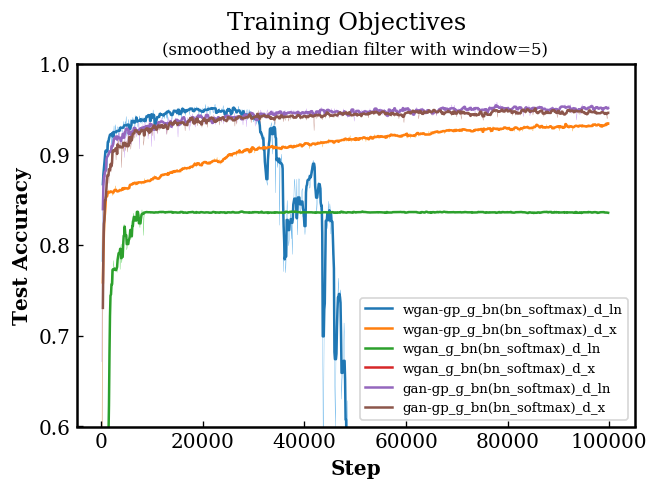

In [13]:
window = 5
for i in [0, 2, 12, 13, 14, 15]:
    plot_acc_curve(test_steps[i], test_accs[i], smooth='med', window=window, label=EXP_DIRS[i][0])
plt.gcf().suptitle('Training Objectives', y=0.99)
plt.title('(smoothed by a median filter with window={})'.format(window), fontsize=10)
plt.xlabel('Step', fontweight='bold')
plt.ylabel('Test Accuracy', fontweight='bold')
plt.ylim(0.6, 1)
plt.yticks(np.arange(0.6, 1.01, 0.1))
plt.tick_params(direction='in')
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.legend(prop={'size':8})
plt.savefig(os.path.join(RESULT_DIR, 'train_objectives.{}'.format(EXTENSION)), bbox_inches='tight')
plt.show()

## Normalization in Generator

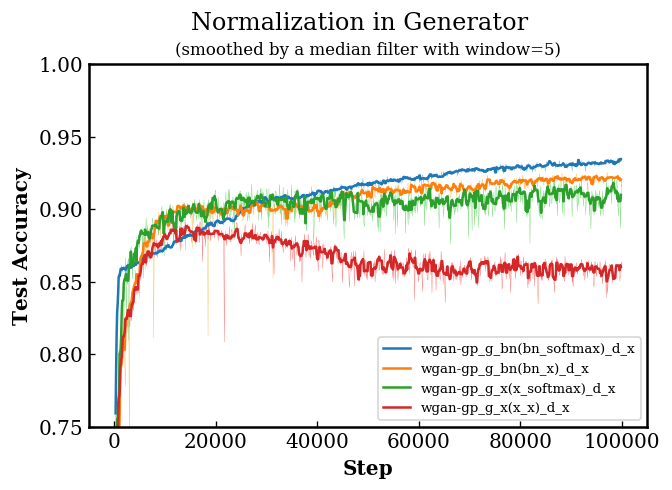

In [14]:
window = 5
for i in [2, 3, 10, 11]:
    plot_acc_curve(test_steps[i], test_accs[i], smooth='med', window=window, label=EXP_DIRS[i][0])
plt.gcf().suptitle('Normalization in Generator', y=0.99)
plt.title('(smoothed by a median filter with window={})'.format(window), fontsize=10)
plt.xlabel('Step', fontweight='bold')
plt.ylabel('Test Accuracy', fontweight='bold')
plt.ylim(0.75, 1.0)
plt.yticks(np.arange(0.75, 1.01, 0.05))
plt.tick_params(direction='in')
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.legend(prop={'size':8}, loc=4)
plt.savefig(os.path.join(RESULT_DIR, 'norm_in_g.{}'.format(EXTENSION)), bbox_inches='tight')
plt.show()

## Output Normalization and Activation in Generator

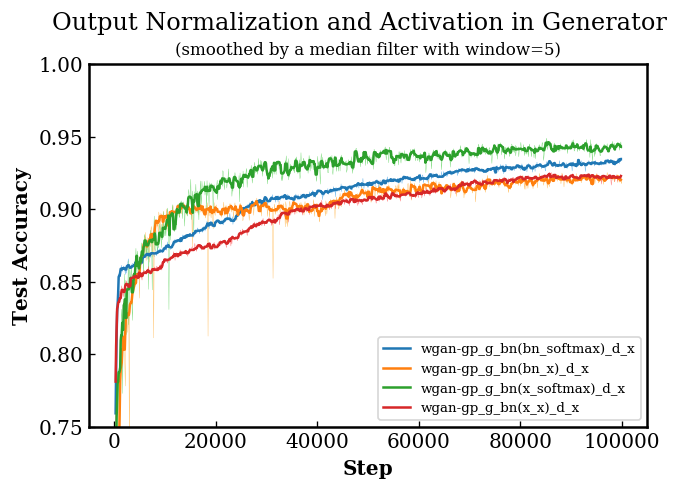

In [15]:
window = 5
for i in [2, 3, 4, 5]:
    plot_acc_curve(test_steps[i], test_accs[i], smooth='med', window=window, label=EXP_DIRS[i][0])
plt.gcf().suptitle('Output Normalization and Activation in Generator', y=0.99)
plt.title('(smoothed by a median filter with window={})'.format(window), fontsize=10)
plt.xlabel('Step', fontweight='bold')
plt.ylabel('Test Accuracy', fontweight='bold')
plt.ylim(0.8, 1.0)
plt.yticks(np.arange(0.75, 1.01, 0.05))
plt.tick_params(direction='in')
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.legend(prop={'size':8}, loc=4)
plt.savefig(os.path.join(RESULT_DIR, 'out_norm_act_in_g.{}'.format(EXTENSION)), bbox_inches='tight')
plt.show()

## Normalization in Discriminator

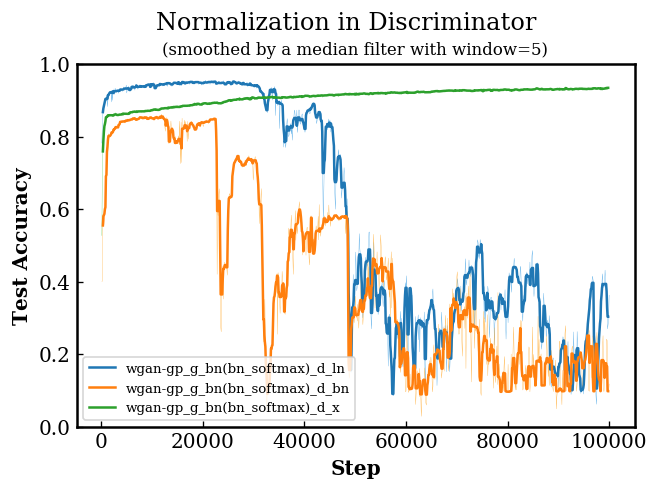

In [16]:
window = 5
for i in [0, 1, 2]:
    plot_acc_curve(test_steps[i], test_accs[i], smooth='med', window=window, label=EXP_DIRS[i][0])
plt.gcf().suptitle('Normalization in Discriminator', y=0.99)
plt.title('(smoothed by a median filter with window={})'.format(window), fontsize=10)
plt.xlabel('Step', fontweight='bold')
plt.ylabel('Test Accuracy', fontweight='bold')
plt.ylim(0, 1)
plt.tick_params(direction='in')
plt.setp(plt.gca().spines.values(), linewidth=1.5)
plt.legend(prop={'size':8})
plt.savefig(os.path.join(RESULT_DIR, 'norm_in_d.{}'.format(EXTENSION)), bbox_inches='tight')
plt.show()